In [1]:
from mind_the_gaps.lightcurves import GappyLightcurve
from mind_the_gaps.gpmodelling import GPModelling
from mind_the_gaps.models.psd_models import BendingPowerlaw, Lorentzian, SHO, Matern32, Jitter
from mind_the_gaps.models.celerite_models import Lorentzian as Lor
from mind_the_gaps.models.celerite_models import DampedRandomWalk
from mind_the_gaps.simulator import Simulator
import numpy as np
import matplotlib.pyplot as plt
import celerite, corner
from scipy.stats import percentileofscore

cpus = 15
np.random.seed(10)

## Case of No period

# Define parameters for lightcurve simulation

In [2]:
times  = np.arange(0, 1000)
dt = np.diff(times)[0]
print("dt", dt)

mean = 100

P = 10
w = 2 * np.pi / P

A = (mean * 0.1) ** 2 # variance of the lorentzian
Q = 80
A_bend = A # variance of the DRW (bending powerlaw)
w_bend = 2 * np.pi / 20 # angular frequency of the DRW or Bending Powerlaw

log_a = np.log(A)
print("log_a", log_a)
log_c = np.log(0.5 * w/Q)
print("log_c", log_c)
log_d = np.log(w)
print("log_d", log_d)

bounds = dict(log_a=(-10, 50), log_c=(-10, 10), log_d=(-5, 5))
bounds_bend = dict(log_a=(-10, 50), log_c=(-10, 10))
# define the PSD model
psd_model = BendingPowerlaw(A_bend, w_bend) 

dt 1
log_a 4.605170185988091
log_c -5.539881841818527
log_d -0.46470802658470023


# Simulate lightcurve

In [3]:
# create simulator object
simulator = Simulator(psd_model, times, np.ones(len(times)) * dt, mean, pdf="Gaussian")
# simulate noiseless count rates from the PSD, make the initial lightcurve 2 times as long as the original times
countrates = simulator.generate_lightcurve(extension_factor = 2)
noisy_rates, dy = simulator.add_noise(rates)

input_lc = GappyLightcurve(times, noisy_rates, dy, exposures=dt)

fig = plt.figure()
plt.errorbar(times, noisy_rates, yerr=dy)
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")

Simulator will use TK95 algorithm with Gaussian pdf


/home/andresgur/anaconda3/lib/python3.9/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


NameError: name 'rates' is not defined

# Define null hypothesis

Deriving posteriors for null model


 12%|████▍                                | 6000/50000 [00:16<02:03, 355.85it/s]


Convergence reached after 6000 samples!


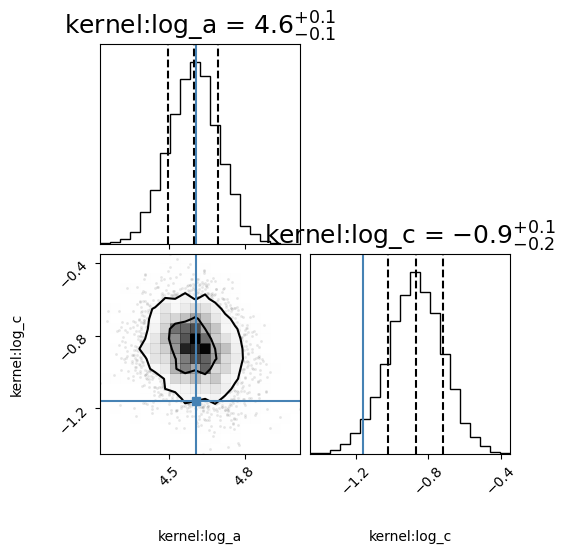

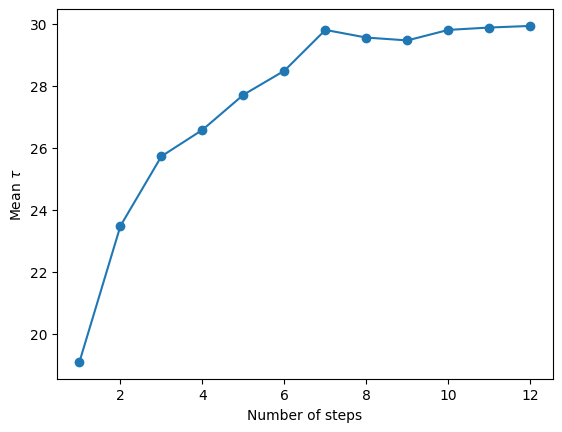

In [13]:

# null 
null_kernel = celerite.terms.RealTerm(log_a=log_a, log_c=np.log(w_bend), bounds=bounds_bend)
null_model = GPModelling(input_lc, null_kernel)
print("Deriving posteriors for null model")
null_model.derive_posteriors(max_steps=50000, fit=True, cores=cpus)

corner_fig = corner.corner(null_model.mcmc_samples, labels=null_model.gp.get_parameter_names(), title_fmt='.1f',
                            quantiles=[0.16, 0.5, 0.84], show_titles=True, truths=[log_a, np.log(w_bend)],
                            title_kwargs={"fontsize": 18}, max_n_ticks=3, labelpad=0.08,
                            levels=(1 - np.exp(-0.5), 1 - np.exp(-0.5 * 2 ** 2))) # plots 1 and 2 sigma levels

autocorr = null_model.autocorr
fig = plt.figure()
n = np.arange(1, len(autocorr) + 1)
plt.plot(n, autocorr, "-o")
plt.ylabel("Mean $\\tau$")
plt.xlabel("Number of steps")
plt.savefig("autocorr.png", dpi=100)

# Define alternative model

Deriving posteriors for alternative model


 48%|█████████████████▎                  | 24000/50000 [01:39<01:48, 240.23it/s]


Convergence reached after 24000 samples!


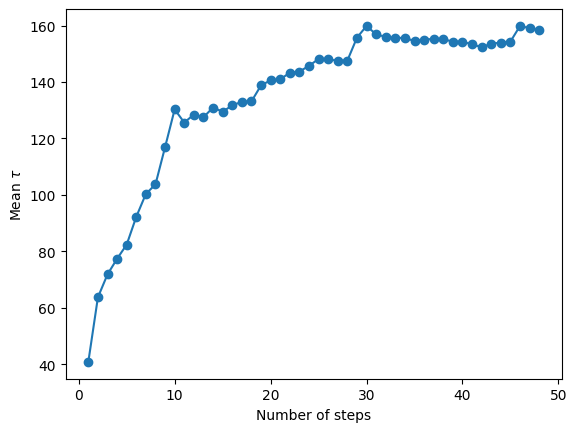

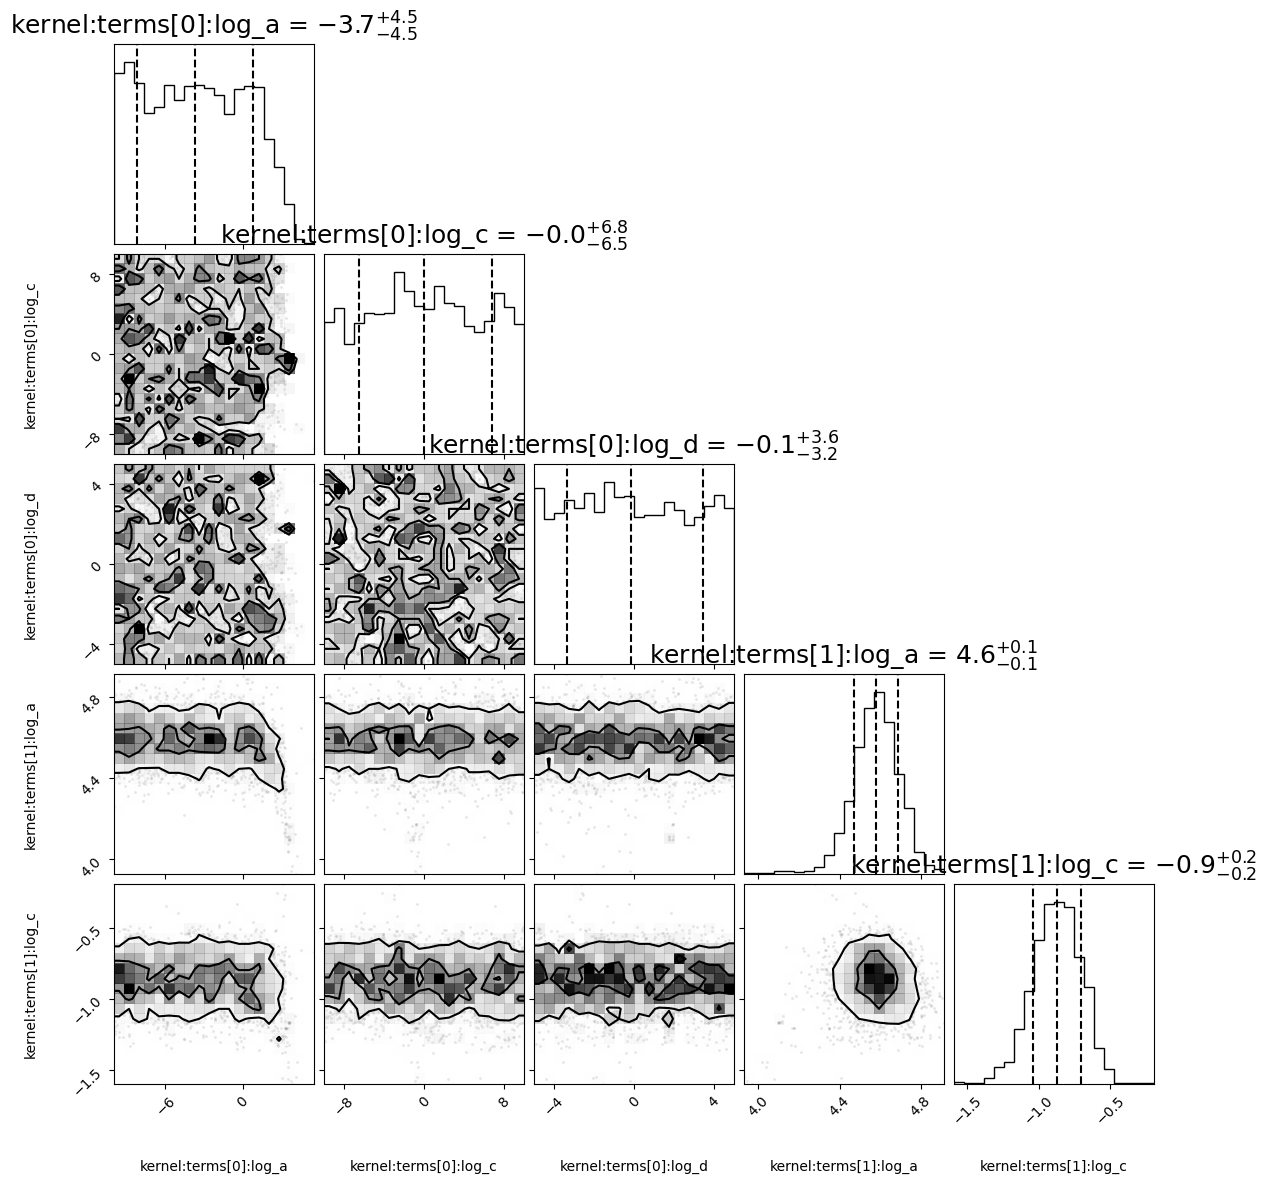

In [14]:
alternative_kernel = celerite.terms.ComplexTerm(log_a=log_a, log_c=np.log(0.5 * w/Q), log_d=log_d, bounds=bounds) \
     + celerite.terms.RealTerm(log_a=log_a, log_c=np.log(w_bend), bounds=bounds_bend)

#bounds = dict(log_S0=(-2, 10), log_Q=(-10, 10), log_omega0=(-5, 5))
#kernel = Lor(np.log(A), np.log(Q), np.log(w), bounds=bounds)

alternative_model = GPModelling(input_lc, alternative_kernel)
print("Deriving posteriors for alternative model")
alternative_model.derive_posteriors(max_steps=50000, fit=True, cores=cpus)

autocorr = alternative_model.autocorr
fig = plt.figure()
n = np.arange(1, len(autocorr) + 1)
plt.plot(n, autocorr, "-o")
plt.ylabel("Mean $\\tau$")
plt.xlabel("Number of steps")
plt.savefig("autocorr.png", dpi=100)

corner_fig = corner.corner(alternative_model.mcmc_samples, labels=alternative_model.gp.get_parameter_names(), title_fmt='.1f',
                            quantiles=[0.16, 0.5, 0.84], show_titles=True,
                            title_kwargs={"fontsize": 18}, max_n_ticks=3, labelpad=0.08,
                            levels=(1 - np.exp(-0.5), 1 - np.exp(-0.5 * 2 ** 2))) # plots 1 and 2 sigma levels





# Generate lightcurves from null hypothesis posteriors

In [15]:
Nsims = 100 # typically 10,000
lcs = null_model.generate_from_posteriors(Nsims, cpus=cpus)
print("Done!")

Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdfSimulator will use TK95 algorithm with Gaussian pdf

Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator wi

# Fit the lightcurves with both null and alternative models

In [16]:
likelihoods_null = []
likelihoods_alt = []

for i, lc in enumerate(lcs):
    print("Processing lightcurve %d/%d" % (i + 1, len(lcs)), end="\r")
    #fig = plt.figure()
    #plt.errorbar(lc.times, lc.y, lc.dy)
    #plt.xlabel("Time (days)")
    #plt.ylabel("Rate (ct/s)")
    #plt.savefig("%d.png" % i, dpi=100)
    
    # Run a small MCMC to make sure we find the global maximum of the likelihood
    # ideally we'd probably want to run more samples
    null_modelling = GPModelling(lc, null_kernel)
    null_modelling.derive_posteriors(fit=True, cores=cpus, walkers=2 * cpus, max_steps=500, progress=False)
    likelihoods_null.append(null_modelling.max_loglikehood)
    alternative_modelling = GPModelling(lc, alternative_kernel)                         
    alternative_modelling.derive_posteriors(fit=True, cores=cpus, walkers=2 * cpus, max_steps=500, 
                                            progress=False)
    likelihoods_alt.append(alternative_modelling.max_loglikehood)
    
                                                                              
print("\nDone!")

Processing lightcurve 100/100
Done!


# Calculate T_LRT distribution and compare with the observed value

[ 6.52448799  4.49395645  5.87105312  2.38442259  4.9080326   2.08972422
  2.47710647  4.50456028  8.66037545  2.18966681  4.67547926 13.01861046
  6.27517542  3.84357261  6.82482233  3.16190017  6.7024128   0.7233808
  9.84565074  6.97285436  9.33872177  4.56940208  2.72085678  4.89070754
  6.2683305   4.04588105  7.02226028  3.15558059  4.89712938  4.43793559
  1.82397444  4.98735676  3.45647359  3.97417883  2.5707406   4.29452424
  2.36917581  2.05291196  2.68668502  4.98697694  3.95385695  6.12239892
  2.79405436  5.36318323  8.40358815  6.44677184  3.15654645  4.84125586
  4.98186344  3.83172218  3.36606318  7.01941411  6.05100232 21.77395161
  5.71878339  4.77671423  4.67239417  2.66256231 11.6702719   4.31835648
 12.07624833 11.50332838  8.68015088  7.67835084  2.30164439  8.91694169
  5.91062988  3.05718161 10.40952198  5.17587306 11.42197344  4.02610635
  5.79727812  4.33158607  3.69557927  2.00628068  3.8784628   2.91854652
  5.43536314  4.61689711  3.25995648  1.96819763  4.

Text(0.5, 0, '$T_\\mathrm{LRT}$')

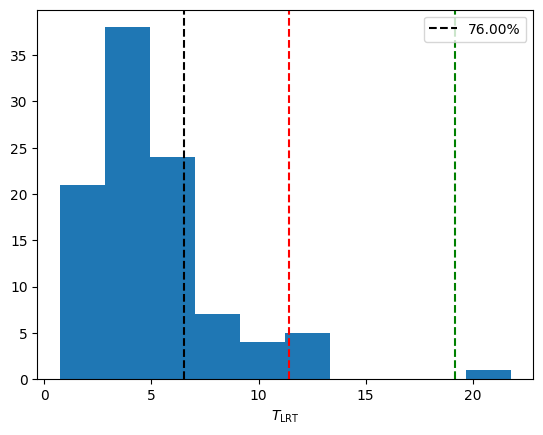

In [17]:
plt.figure()
T_dist = -2 * (np.array(likelihoods_null) - np.array(likelihoods_alt))
print(T_dist)
plt.hist(T_dist, bins=10)
T_obs = -2 * (null_model.max_loglikehood - alternative_model.max_loglikehood)
print("Observed LRT_stat: %.3f" % T_obs)
perc = percentileofscore(T_dist, T_obs)
print("p-value: %.4f" % (1 - perc / 100))
plt.axvline(T_obs, label="%.2f%%" % perc, ls="--", color="black")

sigmas = [95, 99.7]
colors= ["red", "green"]
for i, sigma in enumerate(sigmas):
    plt.axvline(np.percentile(T_dist, sigma), ls="--", color=colors[i])
plt.legend()
#plt.axvline(np.percentile(T_dist, 99.97), color="green")
plt.xlabel("$T_\\mathrm{LRT}$")

#plt.savefig("LRT_statistic.png", dpi=100)

# Case with Period

# Simulate lightcurve

In [32]:
times  = np.arange(0, 500)
dt = np.diff(times)[0]
print("dt", dt)

mean = 100

P = 10
w = 2 * np.pi / P

A = (mean * 0.1) ** 2
Q = 80
A_bend = 2 * A
w_bend = 2 * np.pi / 20

log_a = np.log(A)
print("log_a", log_a)
log_c = np.log(0.5 * w/Q)
print("log_c", log_c)
log_d = np.log(w)
print("log_d", log_d)

bounds = dict(log_a=(-10, 50), log_c=(-10, 10), log_d=(-5, 5))
bounds_bend = dict(log_a=(-10, 50), log_c=(-10, 10))

psd_model = Lorentzian(A, Q, w) + BendingPowerlaw(A_bend, w_bend) 

dt 1
log_a 4.605170185988091
log_c -5.539881841818527
log_d -0.46470802658470023


Simulator will use TK95 algorithm with Gaussian pdf


Text(0, 0.5, 'Rates (ct/s)')

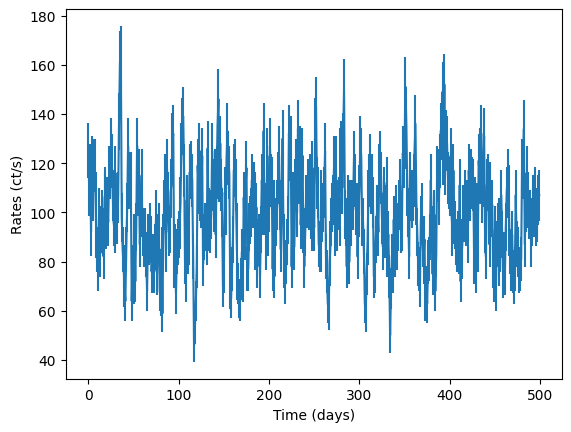

In [33]:
simulator = Simulator(psd_model, times, np.ones(len(times)) * dt, mean, pdf="Gaussian", max_iter=500)

rates = simulator.generate_lightcurve()
noisy_rates, dy = simulator.add_noise(rates)

input_lc = GappyLightcurve(times, noisy_rates, dy, exposures=dt)

fig = plt.figure()
plt.errorbar(times, noisy_rates, yerr=dy)
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")

# Define null hypothesis

Deriving posteriors for null model


 17%|██████▎                              | 8500/50000 [00:27<02:11, 314.73it/s]


Convergence reached after 8500 samples!


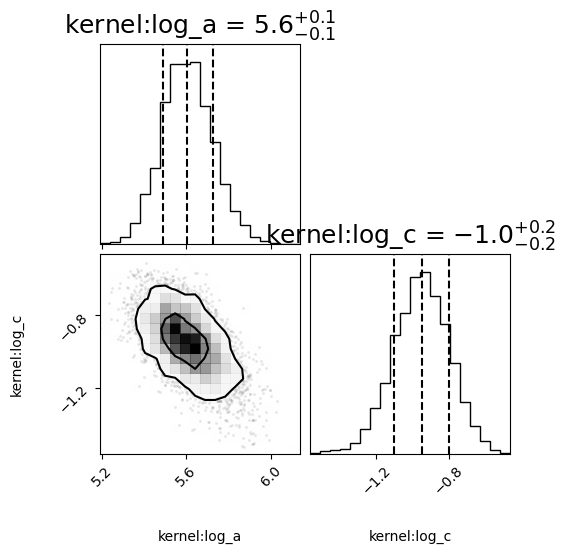

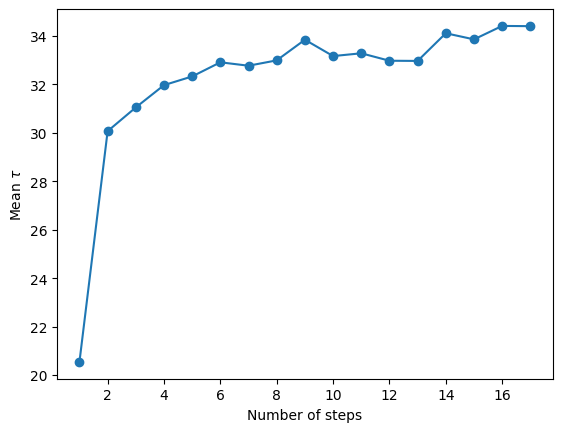

In [34]:

# null 
null_kernel = celerite.terms.RealTerm(log_a=log_a, log_c=np.log(w_bend), bounds=bounds_bend)
null_model = GPModelling(input_lc, null_kernel)
print("Deriving posteriors for null model")
null_model.derive_posteriors(max_steps=50000, fit=True, cores=cpus)

corner_fig = corner.corner(null_model.mcmc_samples, labels=null_model.gp.get_parameter_names(), title_fmt='.1f',
                            quantiles=[0.16, 0.5, 0.84], show_titles=True,
                            title_kwargs={"fontsize": 18}, max_n_ticks=3, labelpad=0.08,
                            levels=(1 - np.exp(-0.5), 1 - np.exp(-0.5 * 2 ** 2))) # plots 1 and 2 sigma levels

autocorr = null_model.autocorr
fig = plt.figure()
n = np.arange(1, len(autocorr) + 1)
plt.plot(n, autocorr, "-o")
plt.ylabel("Mean $\\tau$")
plt.xlabel("Number of steps")
plt.savefig("autocorr.png", dpi=100)

# Define alternative model

Deriving posteriors for alternative model


 34%|████████████▏                       | 17000/50000 [01:09<02:14, 245.55it/s]


Convergence reached after 17000 samples!


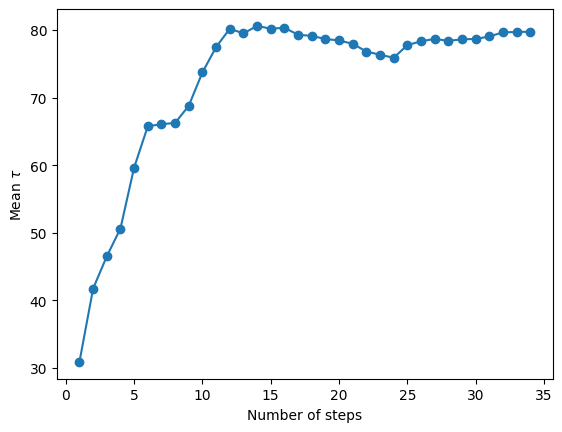

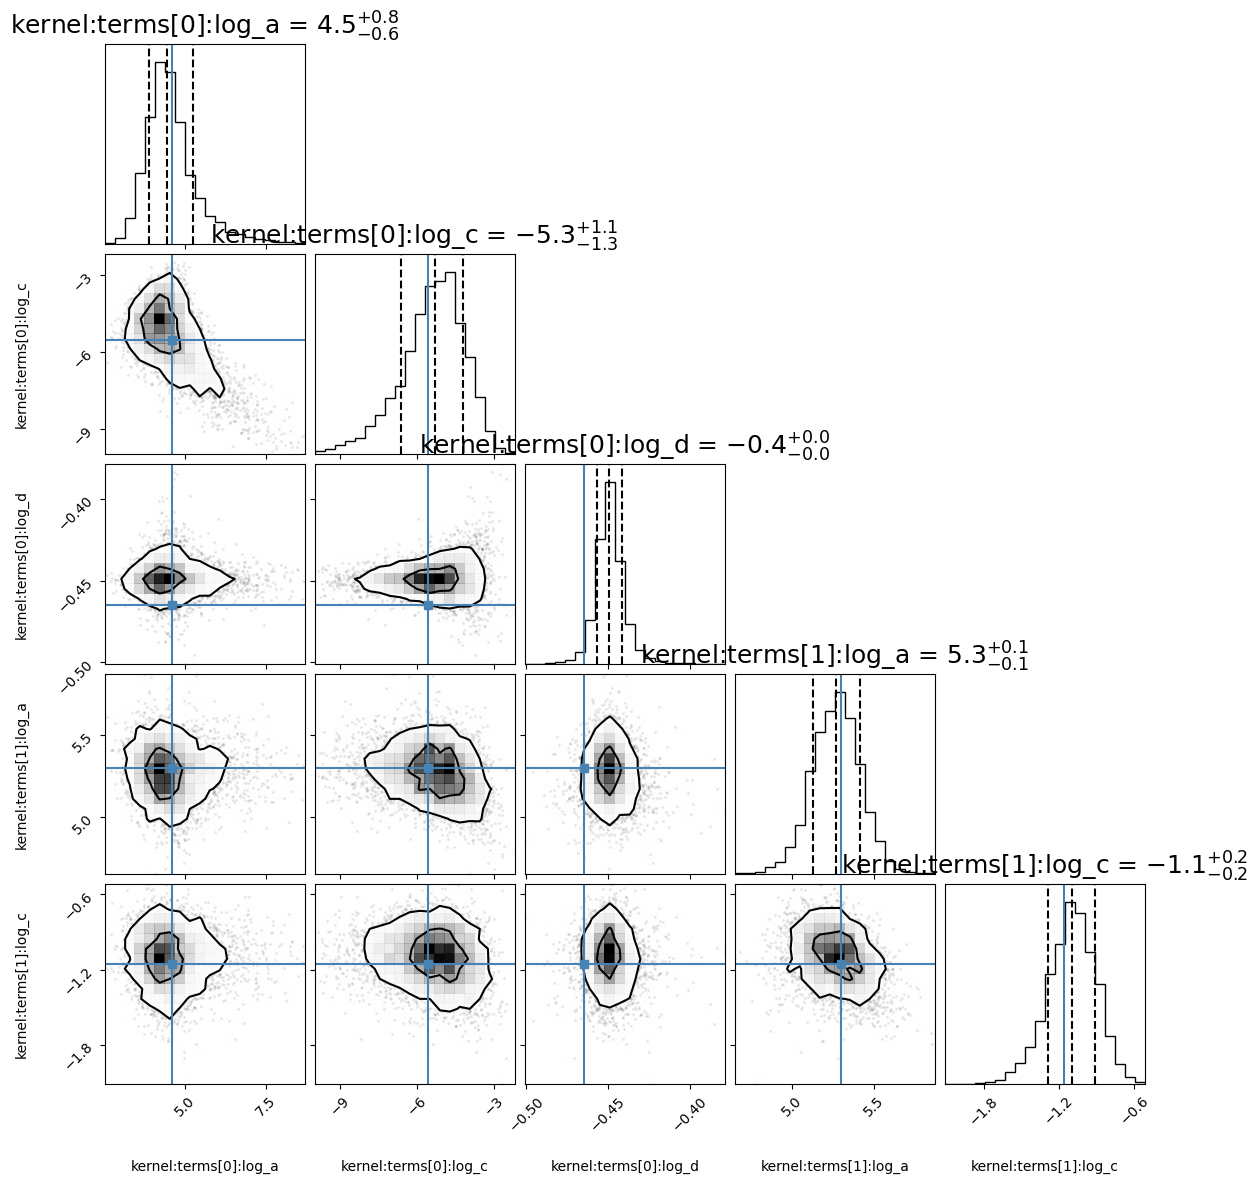

In [37]:
alternative_kernel = celerite.terms.ComplexTerm(log_a=log_a, log_c=np.log(0.5 * w/Q), log_d=log_d, bounds=bounds) \
     + celerite.terms.RealTerm(log_a=log_a, log_c=np.log(w_bend), bounds=bounds_bend)


alternative_model = GPModelling(input_lc, alternative_kernel)
print("Deriving posteriors for alternative model")
alternative_model.derive_posteriors(max_steps=50000, fit=True, cores=cpus)

autocorr = alternative_model.autocorr
fig = plt.figure()
n = np.arange(1, len(autocorr) + 1)
plt.plot(n, autocorr, "-o")
plt.ylabel("Mean $\\tau$")
plt.xlabel("Number of steps")
plt.savefig("autocorr.png", dpi=100)

corner_fig = corner.corner(alternative_model.mcmc_samples, labels=alternative_model.gp.get_parameter_names(), title_fmt='.1f',
                            quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                           truths=[log_a, log_c, log_d, np.log(A_bend), np.log(w_bend)],
                            title_kwargs={"fontsize": 18}, max_n_ticks=3, labelpad=0.08,
                            levels=(1 - np.exp(-0.5), 1 - np.exp(-0.5 * 2 ** 2))) # plots 1 and 2 sigma levels





# Generate lightcurves with null hypothesis posteriors

In [38]:
Nsims = 100 # typically 10,000
lcs = null_model.generate_from_posteriors(Nsims, cpus=cpus)
print("Done!")

Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator wi

# Fit the lightcurves with both null and alternative models

In [39]:
likelihoods_null = []
likelihoods_alt = []

for i, lc in enumerate(lcs):
    print("Processing lightcurve %d/%d" % (i + 1, len(lcs)), end="\r")
    #fig = plt.figure()
    #plt.errorbar(lc.times, lc.y, lc.dy)
    #plt.xlabel("Time (days)")
    #plt.ylabel("Rate (ct/s)")
    #plt.savefig("%d.png" % i, dpi=100)
    
    # Run a small MCMC to make sure we find the global maximum of the likelihood
    # ideally we'd probably want to run more samples
    null_modelling = GPModelling(lc, null_kernel)
    null_modelling.derive_posteriors(fit=True, cores=cpus, walkers=2 * cpus, max_steps=500, progress=False)
    likelihoods_null.append(null_modelling.max_loglikehood)
    alternative_modelling = GPModelling(lc, alternative_kernel)                         
    alternative_modelling.derive_posteriors(fit=True, cores=cpus, walkers=2 * cpus, max_steps=500, 
                                            progress=False)
    likelihoods_alt.append(alternative_modelling.max_loglikehood)
    
                                                                              
print("\nDone!")

Processing lightcurve 100/100
Done!


# Calculate T_LRT distribution and compare with the observed value

[ 2.28028354  2.53048111  3.78390512  3.33686213  3.46649275  1.67408528
  8.70924167  6.73169131  3.04561526  2.21503773  4.12500058  3.75825137
  6.1415742   2.8934624   5.89591985  5.52500467  4.89106421  6.78805598
  4.60297473  8.00219309  6.44223465  6.23089348  2.79846113  4.86108576
  2.31427124  1.77189641  8.0437856   4.86292335  4.37173632  8.11363612
  1.13663662  1.73564601  5.76165833  2.20589767  4.35683323  3.82221309
  2.77385953 12.03229573  6.77770467  5.54139873  7.74750261  2.03847024
  5.46296326  2.67603268  6.5646448   3.04889645  2.59092229  5.08542281
  2.04691286  3.90426884  2.02031522  1.78532962  5.63264511  6.16563145
  1.27473437  3.07511188  1.77047338  0.55004748  7.16412231  6.55563151
  1.99849809  8.01820618  5.09961691  5.04185878  6.59897196  2.48901793
  2.06647851  2.5211985   4.86893098  3.96376611  4.85941204  0.84278053
  1.91531099  2.10992591  1.72190365  3.58043786 12.98372957  0.7672661
  1.66924977  6.64983386  4.06888641  2.74893742  2.

Text(0.5, 0, '$T_\\mathrm{LRT}$')

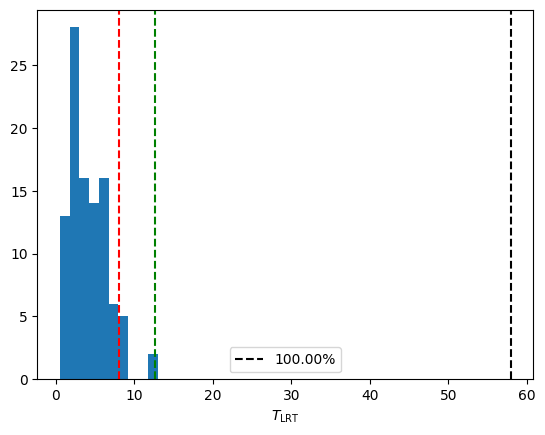

In [40]:
plt.figure()
T_dist = -2 * (np.array(likelihoods_null) - np.array(likelihoods_alt))
print(T_dist)
plt.hist(T_dist, bins=10)
T_obs = -2 * (null_model.max_loglikehood - alternative_model.max_loglikehood)
print("Observed LRT_stat: %.3f" % T_obs)
perc = percentileofscore(T_dist, T_obs)
print("p-value: %.4f" % (1 - perc / 100))
plt.axvline(T_obs, label="%.2f%%" % perc, ls="--", color="black")

sigmas = [95, 99.7]
colors= ["red", "green"]
for i, sigma in enumerate(sigmas):
    plt.axvline(np.percentile(T_dist, sigma), ls="--", color=colors[i])
plt.legend()
#plt.axvline(np.percentile(T_dist, 99.97), color="green")
plt.xlabel("$T_\\mathrm{LRT}$")

#plt.savefig("LRT_statistic.png", dpi=100)